In [37]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import pandas as pd 
import random
import matplotlib.pyplot as plt
import h5py
import os
import google.colab
from utils.file_utils import make_dir


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

##Preprocessing

In [28]:
#download the dataset.
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv


--2020-11-30 04:15:19--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  47.5MB/s    in 4.8s    

2020-11-30 04:15:25 (47.5 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [29]:
#read into pandas to preprocess.
df = pd.read_csv("/tmp/training_cleaned.csv")
print(df.shape)

#dropping all the redundant columns. all we need is the tweet (column 5) and label(column 0).
df.drop(df.columns[1:5], axis=1, inplace=True)
print(df.shape)

#name the columns.
df.columns = ["label", "text"]
print(df.columns)

#change the label 4 to 1. Label 1 will represent positive sentiment. 
df.loc[df.label == 4, "label"] = 1
print(df.tail(10))

#cast to a list of dictionaries.
data = df.to_dict("records") 

(1599999, 6)
(1599999, 2)
Index(['label', 'text'], dtype='object')
         label                                               text
1599989      1                              WOOOOO! Xbox is back 
1599990      1  @rmedina @LaTati Mmmm  That sounds absolutely ...
1599991      1                  ReCoVeRiNg FrOm ThE lOnG wEeKeNd 
1599992      1                                  @SCOOBY_GRITBOYS 
1599993      1  @Cliff_Forster Yeah, that does work better tha...
1599994      1  Just woke up. Having no school is the best fee...
1599995      1  TheWDB.com - Very cool to hear old Walt interv...
1599996      1  Are you ready for your MoJo Makeover? Ask me f...
1599997      1  Happy 38th Birthday to my boo of alll time!!! ...
1599998      1  happy #charitytuesday @theNSPCC @SparksCharity...


[{'label': 1, 'text': 'I love remembering the programs I used to watch when I was little  Like Captain Planet, Xmen, Spiderman, Tundercats, count duckula!! lol'}, {'label': 1, 'text': '@lizstrauss thank you '}, {'label': 1, 'text': 'Night at the Musuem was hilarious. I totally want to watch it again! &quot;Awkward.....&quot; '}, {'label': 1, 'text': "@sweetlilmzmia hun,u forgot 86 after the cow  and that's the pic i didn't wanna post haha! Hawt )"}, {'label': 1, 'text': 'going to Disney '}, {'label': 0, 'text': "Not really feeling like myself these past couple days. I've really been white knuckling it "}, {'label': 1, 'text': '@LaurHogan thank you missus hogan,im finally here  xxx'}, {'label': 1, 'text': 'Cooking Curry Chicken,Rice,Potatoes,green peas an corn!!! Its about to go real crazy in this kitchen! Dinner going to be Ovah tonite! '}, {'label': 1, 'text': 'In Cleveland, Ohio. Been there done that. '}, {'label': 1, 'text': '#Music Monday: dead and gone by JT!!!! happy music monday

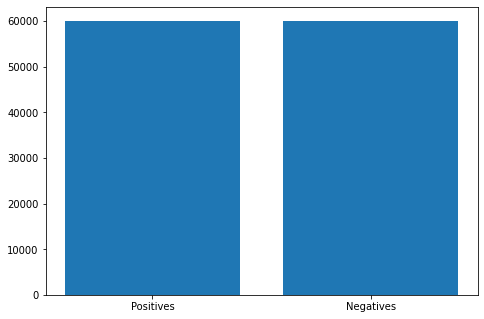

In [30]:
#shuffle the data and downsize from 1.6M to 100K train, 10k test, 10k validation.
random.shuffle(data)

data = data[:120000]

print(data[:50])

print(data[:10])

num_negative = 0
num_positive = 0 

for i in data:
  if i["label"] == 0:
    num_positive+=1
  else:
    num_negative +=1 

#As seen here, we have a balanced distribution of positives and negatives in the downsized dataset.
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Positives', "Negatives"]
tallies = [num_positive, num_negative]
ax.bar(labels,tallies)
plt.show()

##Tokenizing and Padding the Tweets

In [31]:
tweets = []
labels = [] 

for i in data:
  tweets.append(i["text"])
  labels.append(i["label"])

tokenizer = Tokenizer() # no upper limit on number of words. 
tokenizer.fit_on_texts(tweets)

word_index = tokenizer.word_index 
vocab_size = len(word_index) # number of unique words discovered in the corpus. 
print(vocab_size)

#tokenizing the sentences into sequences of tokens. 
sequences = tokenizer.texts_to_sequences(tweets)

#padding sequences of tokens to ensure they're the same length (which I set to 32) here. Tweets are short.
padded = pad_sequences(sequences, maxlen=32, padding = "post", truncating="post")

112645


##Split into Test and Training Sets.

In [32]:
#100k train, 10k test, 10k validation. 

validation_tweets = padded[:10000] 
validation_labels = np.array(labels[:10000])

test_tweets = padded[10000:20000]
test_labels = np.array(labels[10000:20000])

train_tweets = padded[20000:]
train_labels = np.array(labels[20000:])


print(len(validation_tweets), len(validation_labels))
print(len(test_tweets), len(test_labels))
print(len(train_tweets), len(train_labels))


print(type(train_tweets))
print(train_tweets.shape)
print(type(train_labels))
print(train_labels.shape)


10000 10000
10000 10000
100000 100000
<class 'numpy.ndarray'>
(100000, 32)
<class 'numpy.ndarray'>
(100000,)


##Writing into .h5 files.

In [33]:
from google.colab import drive
drive.mount('/content/drive')

#%cd drive/MyDrive/cmsc_35200_set/
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cmsc_35200_set


In [40]:
ROOT_PATH = "/content/drive/MyDrive/cmsc_35200_set/utils/datasets/sentiment/"
#TEST_PATH = os.path.join(ROOT_PATH, "test")
#VALIDATION_PATH = os.path.join(ROOT_PATH, "validation")
#TRAIN_PATH = os.path.join(ROOT_PATH, "train")

def write_h5py_dataset(sequences: np.ndarray, labels: np.ndarray, path: str):
    make_dir(os.path.split(path)[0])

    assert sequences.shape[0] == labels.shape[0], 'Misaligned images and labels'

    with h5py.File(path, 'w') as fout:
        inputs = fout.create_dataset("inputs", sequences.shape, dtype='i')
        inputs.write_direct(sequences)

        output = fout.create_dataset("output", (len(labels), ), dtype='i')
        output.write_direct(labels)


write_h5py_dataset(train_tweets, train_labels, os.path.join(ROOT_PATH, "train", "data.h5"))
write_h5py_dataset(test_tweets, test_labels, os.path.join(ROOT_PATH, "test", "data.h5"))
write_h5py_dataset(validation_tweets, validation_labels, os.path.join(ROOT_PATH, "validation", "data.h5"))
